### FIR fraction as a function of blackbody temperature.

In [8]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

Script-specific imports

In [1]:
import scipy.special as sc
from scipy.integrate import quad

### Check running location and adjust working directory appropriately.

In [9]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


Integrate the Planck function to calculate the fraction of emitted energy in the FIR for a range of earth-like surface temperatures.

Planck function (for wavelength):

$ L = \frac{2hc^2}{\lambda^5}\frac{1}{e^{hc/\lambda kT} - 1} $

$ [\frac{W}{sr m^2 m} ]$

Stefan-Boltzmann Law:

$ \sigma = \frac{2\pi^5k^4}{15h^3c^2}T^4 $ [W/m^2]

Constants:

In [10]:
h=6.626e-34 # m2kgs-1
c=3e8 # m/s
k=1.38e-23 # m2kgs-2K-1
p=np.pi

In [60]:
def planck(lam, T):
    l = 2*h*c**2/(lam**5) * 1/(np.exp(h*c/(lam*k*T))-1)
    return l

def s_b(T):
    sig = (2*p**5*k**4)/(15*h**3*c**2)*(T**4)
    
    return sig

In [62]:
s_b(255) / (4*np.pi)

19.017722206002933

In [151]:
def fir_fraction(T):
    tot = quad(planck,0,np.inf,args=(T))[0]
    fir = quad(planck,15e-6,np.inf,args=(T))[0]
    
    return fir/tot *100

In [154]:
all_t = np.arange(220,301,1)

In [155]:
plt.plot(fir_fraction(all_t),all_t)

TypeError: only size-1 arrays can be converted to Python scalars

In [150]:
T = 220

# quad(planck,0,np.inf,args=(T))
quad(planck,0,1e-1,args=(T)) #[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


42.14523620415981

In [146]:
T = 220

quad(planck,0,np.inf,args=(T))
# quad(planck,0,200e-6,args=(T))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  This is separate from the ipykernel package so we can avoid doing imports until


(42.1459631626696, 18.548235923975774)

In [143]:
T = 220

quad(planck,15e-6,np.inf,args=(T))

(27.846361489604377, 5.644213168945564e-10)

In [144]:
27.846/42.146

0.6607032695866749

In [136]:
all_ = np.trapz(planck(lams,220),x=lams)

In [137]:
fir_ = np.trapz(planck(lams[149:],220),x=lams[149:])

In [140]:
print(all_)
print(fir_)

41.67417172920671
27.375362063038214


In [138]:
fir_ / all_

0.6568903694336079

In [95]:
np.trapz(planck(fir_lams,220),x=fir_lams)

0.0

In [107]:
len(lams[500:])

500

In [115]:
lams[834]

1.4933932161242534e-05

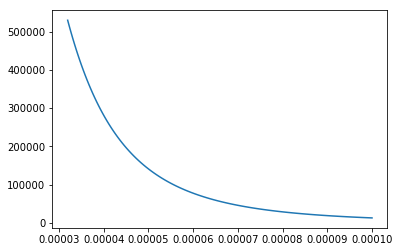

In [110]:
plt.plot(lams[0:],planck(lams[900:],220))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


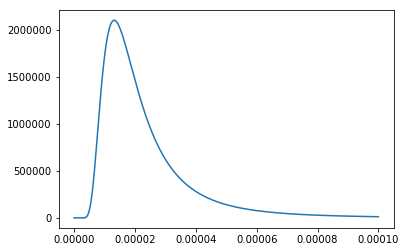

In [103]:
plt.plot(lams,planck(lams,220))

In [105]:
len(lams)

1000

In [68]:
def planck(lam, T):
    l = 2*h*c**2/(lam**5) * 1/(np.exp(h*c/(lam*k*T))-1)
    return l

Pick wavelength range of interest (1nm - 100um) and temperature range of interest (220 K - 300 K)

In [127]:
# Wavelength range is from 100nm to 100um
# lams = np.logspace(-7,-4,1e3)
lams = np.linspace(100e-9,100e-6,1e3) # linear sampling, hopefully resolution is still good
# fir_lams = np.arange(15e-6,100e-6,1e3)
t_range1 = np.arange(220,301,20)

In [121]:
# Quick function to convert wavelength ticks from m to um
def format_func(value, tick_number):
#     print(type(value*1e6))
#     print("%.0f" % value*1e6)
    return np.round(value*1e6, decimals=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  This is separate from the ipykernel package so we can avoid doing imports until


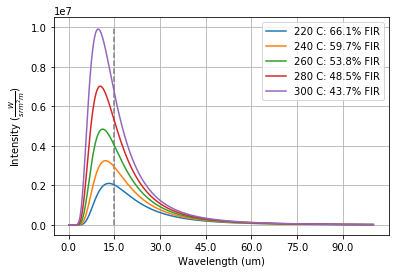

In [169]:
fig, ax = plt.subplots()

for i in t_range1:
    ax.plot(lams,planck(lams,i),label="%.0f C: %.1f%% FIR" % (i, 100*fir_fraction(i)))
#     print(fir_fraction(i))
    ax.grid()

ax.set_xlabel("Wavelength (um)")
ax.set_ylabel(r"Intensity ($ \frac{W}{sr m^2 m} )$")

# Make ticks in microns
ax.set_xticks(np.arange(0,91e-6,15e-6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

# ax.set_xscale('log')
ax.vlines(15e-6,ymin=0,ymax=1e7,color='gray',linestyle='dashed')

plt.legend()

In [14]:
# https://stackoverflow.com/questions/22417484/plancks-formula-for-blackbody-spectrum

# import matplotlib.pyplot as plt
# import numpy as np

h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def planck2(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


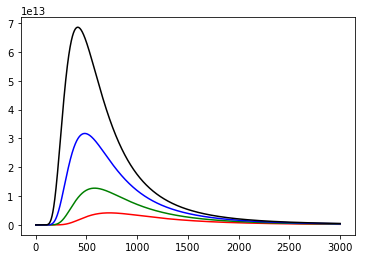

In [59]:
# generate x-axis in increments from 1nm to 3 micrometer in 1 nm increments
# starting at 1 nm to avoid wav = 0, which would result in division by zero.
wavelengths = np.arange(1e-9, 3e-6, 1e-9) 

# intensity at 4000K, 5000K, 6000K, 7000K
intensity4000 = planck(wavelengths, 4000.)
intensity5000 = planck(wavelengths, 5000.)
intensity6000 = planck(wavelengths, 6000.)
intensity7000 = planck(wavelengths, 7000.)

plt.hold(True) # doesn't erase plots on subsequent calls of plt.plot()
plt.plot(wavelengths*1e9, intensity4000, 'r-') 
# plot intensity4000 versus wavelength in nm as a red line
plt.plot(wavelengths*1e9, intensity5000, 'g-') # 5000K green line
plt.plot(wavelengths*1e9, intensity6000, 'b-') # 6000K blue line
plt.plot(wavelengths*1e9, intensity7000, 'k-') # 7000K black line

# show the plot
plt.show()